In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import json
import pandas as pd
from scipy.interpolate import interp1d
sns.set(style="whitegrid")

In [4]:
models = [
    'dpp',
    'qmix', 
    'coma', 
#     'iql', 
#     'centralV',
    'noisemix', 
    'vdn',
    'qtran'
]

model_names = {
    'dpp': 'Q-DPP (Ours)',
    'qmix': 'QMIX', 
    'coma': 'COMA', 
    'iql': 'IQL', 
    'centralV': 'CentralV',
    'noisemix': 'MAVEN', 
    'vdn': 'VDN',
    'qtran': 'QTRAN'
}

game = 'Multi-Step Matrix'
df = None

fields = ['ep_return_T', 'ep_return', 'return_mean_T', 'return_mean', 'test_return_mean_T', 'test_return_mean']

def smoothing(vs,p=0., model='dpp'):
    rsts = []
    last = vs[0]
    for i, v in enumerate(vs):
#         if model != 'dpp' and model != 'coma':
#             v = v*2.5
        if i == 0:
            smoothed = v
        else:
            smoothed =  last*p + (1-p)*v
        rsts.append(smoothed)
        last = smoothed
    return np.array(rsts)

for model in models:
    log_dir = '../result_final/nstep_matrix/{}/*/info.json'.format(model)
    log_paths = glob(log_dir)
    log_paths += glob(log_dir.replace('json', 'csv'))
    print(log_paths)
    x_inx = None
    for path in log_paths:

        try:
            if 'json' in path:
                log = json.load(fp=open(path, 'r'))
                log_selected = {field:log[field] for field in fields if field in log.keys()}
            else:
#                 path = path.replsace('json', 'csv')
                log_pd = pd.read_csv(path)
#                 print(log_pd)
                log_selected = {}
                log_selected['return_mean_T']= log_pd['Step'].values
                log_selected['return_mean']= log_pd['Value'].values         
#             log_df = pd.DataFrame.from_dict(log, orient='index').transpose()
        except:
                print('read fail', path)
                continue

        y_column = 'return_mean'
        x_column = 'return_mean_T'
        x = np.asarray(log_selected[x_column])
        print(x[-1])
        if x_inx is None:
            x_inx = x
            if x_inx[-1] + 6000 > 100000:
                x_inx[-1]= 100000
        y = smoothing(smoothing(np.asarray(log_selected[y_column]), model=model))
        x = x_inx[0:len(y)]
        print(x.shape, y.shape)
        log_df = pd.DataFrame(list(zip(x, y)), 
           columns =['Step', 'Return']) 
        log_df['Model'] = log_df['Step'].apply(lambda x: model_names[model])
        log_df['run'] = log_df['Step'].apply(lambda x: path)
        if df is None:
            df = log_df

        else:
            df = pd.concat([df, log_df], ignore_index=True)
        print(path)

df = df.dropna()
df = df.astype({'Step': 'int32', 'Return': 'float32'})

['../result_final/nstep_matrix/dpp/1/info.json', '../result_final/nstep_matrix/dpp/3/info.csv', '../result_final/nstep_matrix/dpp/2/info.csv']
99113
(100,) (100,)
../result_final/nstep_matrix/dpp/1/info.json
46143
(47,) (47,)
../result_final/nstep_matrix/dpp/3/info.csv
21089
(22,) (22,)
../result_final/nstep_matrix/dpp/2/info.csv
['../result_final/nstep_matrix/qmix/1/info.json', '../result_final/nstep_matrix/qmix/3/info.json', '../result_final/nstep_matrix/qmix/2/info.json', '../result_final/nstep_matrix/qmix/5/info.json']
98342
(99,) (99,)
../result_final/nstep_matrix/qmix/1/info.json
99377
(99,) (100,)
../result_final/nstep_matrix/qmix/3/info.json
99377
(99,) (100,)
../result_final/nstep_matrix/qmix/2/info.json
99364
(99,) (100,)
../result_final/nstep_matrix/qmix/5/info.json
['../result_final/nstep_matrix/coma/1/info.json', '../result_final/nstep_matrix/coma/3/info.json', '../result_final/nstep_matrix/coma/2/info.json', '../result_final/nstep_matrix/coma/5/info.json']
96147
(94,) (94

/Users/yingwen/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


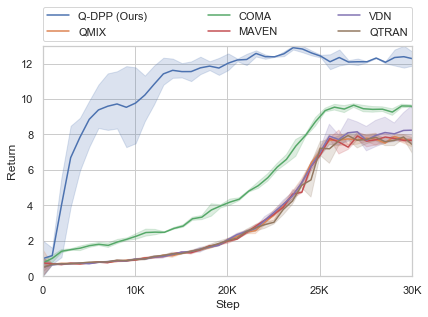

In [7]:
plt.figure(figsize=(6,4))
sns.set(font_scale=1., style="whitegrid")
ax = sns.lineplot(x="Step", y="Return",
             hue="Model", err_style='band',
             data=df)
# plt.title(game)
plt.tight_layout(pad=1)
ax.set_xlim(0., 40000)
ax.set_ylim(0., 13.)
# ax.set_yticks([-40, -30, -20, -10, -5, -3, 0])
ax.set_xticks([0,  10000,  20000, 30000, 40000])
ax.set_xticklabels(['0',  '10K',  '20K', '25K', '30K', '40K'])
# lgd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles=handles[1:], labels=labels[1:], 
                bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3)
plt.savefig('{}_lc.pdf'.format(game.replace(' ', '')), bbox_extra_artists=(lgd,), bbox_inches='tight')

In [23]:
# log_paths = glob('./results/grid/{}/dpp/*/info.json'.format(game))
# path = log_paths[-1]
# log = json.load(fp=open(path, 'r'))
#         log_selected = {field:log[field] for field in fields}

In [24]:
# log.keys()